In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import datetime
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import statsmodels.api as sm

np.random.seed = 42
df = pd.read_csv('C:\data\corona\df13.csv', sep=',')
print(df.head())
print(df.columns)

         date  county-identifier             county  area in sq. km  \
0  2020-02-16               5370          Heinsberg          627.91   
1  2020-02-17               5370          Heinsberg          627.91   
2  2020-02-17               5158           Mettmann          407.22   
3  2020-02-18               5370          Heinsberg          627.91   
4  2020-02-18               5111  Düsseldorf, Stadt          217.41   

   total population  population per sq. km  percentage of infected  \
0            255555                    407                0.000016   
1            255555                    407                0.000008   
2            485570                   1192                0.000002   
3            255555                    407                0.000004   
4            621877                   2860                0.000002   

   average unemployment rate 2019  disposable income per inhabitant (€)  \
0                        0.026666                                 20631   
1 

In [2]:
df['school lessons'] = 'school-' + df['school lessons'].astype(str)
df['university lectures'] = 'uni-' + df['university lectures'].astype(str)
df['restaurants'] = 'rest.-' + df['restaurants'].astype(str)
df['number of guests at a wedding'] = 'wed.-' + df['number of guests at a wedding'].astype(str)
df['number of people you can meet in public'] = 'meet-' + df['number of people you can meet in public'].astype(str)

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].apply(lambda time: time.dayofweek)
print(df.head())

        date  county-identifier             county  area in sq. km  \
0 2020-02-16               5370          Heinsberg          627.91   
1 2020-02-17               5370          Heinsberg          627.91   
2 2020-02-17               5158           Mettmann          407.22   
3 2020-02-18               5370          Heinsberg          627.91   
4 2020-02-18               5111  Düsseldorf, Stadt          217.41   

   total population  population per sq. km  percentage of infected  \
0            255555                    407                0.000016   
1            255555                    407                0.000008   
2            485570                   1192                0.000002   
3            255555                    407                0.000004   
4            621877                   2860                0.000002   

   average unemployment rate 2019  disposable income per inhabitant (€)  \
0                        0.026666                                 20631   
1       

In [3]:
def onehot_enc(df, col):
    enc_oh = OneHotEncoder(sparse=False)
    enc_oh.fit(df[[col]])
    category_columns = np.concatenate(enc_oh.categories_)
    encoded_features = enc_oh.transform(df[[col]])

    df[category_columns] = pd.DataFrame(
            encoded_features,
            columns=category_columns,
            index=df.index)
    return df.drop([col], axis =1)

onehot_enc(df, 'school lessons')
onehot_enc(df, 'university lectures')
onehot_enc(df, 'restaurants')
onehot_enc(df, 'number of guests at a wedding')
onehot_enc(df, 'number of people you can meet in public')
print(df.dtypes)
print(df)

date                                                                                                              datetime64[ns]
county-identifier                                                                                                          int64
county                                                                                                                    object
area in sq. km                                                                                                           float64
total population                                                                                                           int64
population per sq. km                                                                                                      int64
percentage of infected                                                                                                   float64
average unemployment rate 2019                                                                   

In [4]:
df['previous day'] = df['date'] - datetime.timedelta(days=1)

df_join = df.filter(['date','county-identifier','percentage of infected'], axis=1)
df_join = df_join.rename(columns={'date': 'previous day'})
df_join = df_join.rename(columns={'percentage of infected': '% infected previous day'})
print(df_join.head())

df1 = pd.merge(df, df_join, on = ['previous day', 'county-identifier'], how = 'inner')
print(df1.dtypes)

  previous day  county-identifier  % infected previous day
0   2020-02-16               5370                 0.000016
1   2020-02-17               5370                 0.000008
2   2020-02-17               5158                 0.000002
3   2020-02-18               5370                 0.000004
4   2020-02-18               5111                 0.000002
date                                                                                                              datetime64[ns]
county-identifier                                                                                                          int64
county                                                                                                                    object
area in sq. km                                                                                                           float64
total population                                                                                                           int64
p

In [5]:
df['previous week'] = df['date'] - datetime.timedelta(days=7)

df_join2 = df.filter(['date','county-identifier','percentage of infected'], axis=1)
df_join2 = df_join2.rename(columns={'date': 'previous week'})
df_join2 = df_join2.rename(columns={'percentage of infected': '% infected previous week'})
print(df_join2.head())

df2 = pd.merge(df, df_join2, on = ['previous week', 'county-identifier'], how = 'inner')
print(df2)
print(df2.dtypes)

  previous week  county-identifier  % infected previous week
0    2020-02-16               5370                  0.000016
1    2020-02-17               5370                  0.000008
2    2020-02-17               5158                  0.000002
3    2020-02-18               5370                  0.000004
4    2020-02-18               5111                  0.000002
            date  county-identifier             county  area in sq. km  \
0     2020-02-23               5370          Heinsberg          627.91   
1     2020-02-24               5370          Heinsberg          627.91   
2     2020-02-25               5370          Heinsberg          627.91   
3     2020-02-25               5111  Düsseldorf, Stadt          217.41   
4     2020-02-26               5382   Rhein-Sieg-Kreis         1153.21   
...          ...                ...                ...             ...   
14889 2021-02-03               5370          Heinsberg          627.91   
14890 2021-02-03               5111  Düsse

In [7]:
#linear model with % infected previous day
X=df1.drop(df1[['percentage of infected', 'date', 'previous day', 'county', 'county-identifier', 
                'school lessons', 'university lectures', 'restaurants', 'number of guests at a wedding',
               'number of people you can meet in public', 'mean infection rate-7d',  'mean infection rate-14d',  
                 'change of infection rate']], axis =1)
Y=df1[['percentage of infected']]
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.2, random_state=42)
Y_test, Y_train = Y_test.values.ravel(), Y_train.values.ravel()

#print(df1.dtypes)
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
print(reg.score(X_test, Y_test), 1 - (1-reg.score(X_test, Y_test))*(len(Y_test)-1)/(len(Y_test)-X_train.shape[1]-1))

0.7753667653077627 0.7722071551747842


In [17]:
#linear model with % infected previous week
X2=df2.drop(df2[['percentage of infected', 'date', 'previous day', 'previous week', 'county', 'county-identifier', 
                'school lessons', 'university lectures', 'restaurants', 'number of guests at a wedding',
               'number of people you can meet in public', 'mean infection rate-7d',  'mean infection rate-14d',  
                 'change of infection rate']], axis =1)
Y2=df2[['percentage of infected']]
X_train2, X_test2, Y_train2, Y_test2 =train_test_split(X2, Y2, test_size=0.2, random_state=42)
Y_test2, Y_train2 = Y_test2.values.ravel(), Y_train2.values.ravel()

print(X2.columns)
#print(df1.dtypes)
reg2 = linear_model.LinearRegression()
reg2.fit(X_train2, Y_train2)
print(reg.score(X_test2, Y_test2), 1 - (1-reg.score(X_test2, Y_test2))*(len(Y_test2)-1)/(len(Y_test2)-X_train2.shape[1]-1))

Index(['area in sq. km', 'total population', 'population per sq. km',
       'average unemployment rate 2019',
       'disposable income per inhabitant (€)', 'CDU%', 'SPD%', 'FDP%', 'AfD%',
       'Bündnis 90/Die Grünen%', 'DIE LINKE%', 'PIRATEN%', 'other parties%',
       'obligation to wear a mask in shops', 'weekday', 'school-holidays',
       'school-in-class lessons for graduation classes',
       'school-in-class lessons with masks',
       'school-in-class lessons without masks',
       'school-in-class lessons, for primary school pupils without masks',
       'school-in-class lessons, partially with masks', 'school-online',
       'school-part-time in-class lessons',
       'school-part-time in-class lessons for primary school pupils and last three oldest classes of secondary schools',
       'uni-holidays', 'uni-online', 'rest.-closed', 'rest.-open',
       'rest.-open with restrictions',
       'wed.-celebration with two households, except family',
       'wed.-hygiene concep

In [9]:
#Random Forest with previous day
reg_rf = RandomForestRegressor(random_state = 42) 
reg_rf.fit(X_train, Y_train)
pred_rf = reg_rf.predict(X_test)

print(r2_score(Y_test, pred_rf), 1 - (1-r2_score(Y_test, pred_rf))*(len(pred_rf)-1)/(len(pred_rf)-X_train.shape[1]-1))

0.8079717683160985 0.8052707684062781


In [10]:
#Random Forest with previous week
reg_rf2 = RandomForestRegressor(random_state = 42) 
reg_rf2.fit(X_train2, Y_train2)
pred_rf2 = reg_rf2.predict(X_test2)

print(r2_score(Y_test2, pred_rf2), 1 - (1-r2_score(Y_test2, pred_rf2))*(len(pred_rf2)-1)/(len(pred_rf2)-X_train2.shape[1]-1))

0.7584650847944043 0.7550098850537248


In [11]:
#decision week with previous day
tree = DecisionTreeRegressor(random_state = 42)
tree = tree.fit(X_train, Y_train)
pred_tree = tree.predict(X_test)
print(r2_score(Y_test, pred_tree), 1 - (1-r2_score(Y_test, pred_tree))*(len(pred_tree)-1)/(len(pred_tree)-X_train.shape[1]-1))

0.6109840635013677 0.6055123055198062


In [12]:
#decision week with previous week
tree2 = DecisionTreeRegressor(random_state = 42)
tree2 = tree2.fit(X_train2, Y_train2)
pred_tree2 = tree2.predict(X_test2)
print(r2_score(Y_test2, pred_tree2), 1 - (1-r2_score(Y_test2, pred_tree2))*(len(pred_tree2)-1)/(len(pred_tree2)-X_train2.shape[1]-1))

0.5966119179374365 0.5908413799787758


In [13]:
#ols previous day
X_train_int = sm.add_constant(X_train) 
est = sm.OLS(Y_train, X_train_int)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     868.9
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:55:16   Log-Likelihood:             1.0073e+05
No. Observations:               12112   AIC:                        -2.014e+05
Df Residuals:                   12075   BIC:                        -2.011e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [14]:
#ols previous week
X_train_int2 = sm.add_constant(X_train2) 
est3 = sm.OLS(Y_train2, X_train_int2)
est4 = est3.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     881.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:55:16   Log-Likelihood:                 99196.
No. Observations:               11915   AIC:                        -1.983e+05
Df Residuals:                   11878   BIC:                        -1.980e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

(6.58660775522031e-07,
 0.0010080211509120003,
 1.670432616473395e-06,
 0.0010090329227529517)

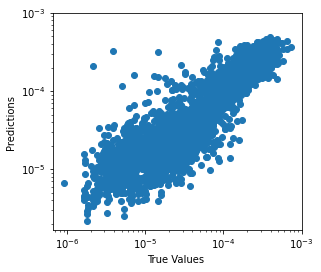

In [15]:
g=plt.scatter(Y_test, pred_rf)
g.axes.set_yscale('log')
g.axes.set_xscale('log')
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')

In [16]:
#linear model AfD
X3=df2[['AfD%']]
Y3=df2[['percentage of infected']]
X_train3, X_test3, Y_train3, Y_test3 =train_test_split(X3, Y3, test_size=0.2, random_state=42)
Y_test3, Y_train3 = Y_test3.values.ravel(), Y_train3.values.ravel()

X_train_int3 = sm.add_constant(X_train3) 
est3 = sm.OLS(Y_train3, X_train_int3)
est5 = est3.fit()
print(est5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     136.4
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           2.37e-31
Time:                        08:55:18   Log-Likelihood:                 91516.
No. Observations:               11915   AIC:                        -1.830e+05
Df Residuals:                   11913   BIC:                        -1.830e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.395e-05   4.67e-06      9.411      0.0

In [18]:
numeric_attributes = ['area in sq. km', 'total population', 'population per sq. km',
                      'average unemployment rate 2019', 'disposable income per inhabitant (€)', 
                      'CDU%', 'SPD%', 'FDP%', 'AfD%', 'Bündnis 90/Die Grünen%', 'DIE LINKE%', 'PIRATEN%', 
                      'other parties%']


for n in numeric_attributes: 
    Xn=df[[n]]
    Yn=df[['percentage of infected']]
    X_trainn, X_testn, Y_trainn, Y_testn =train_test_split(Xn, Yn, test_size=0.2, random_state=42)
    Y_testn, Y_trainn = Y_testn.values.ravel(), Y_trainn.values.ravel()
    X_train_intn = sm.add_constant(X_trainn) 
    estn1 = sm.OLS(Y_trainn, X_train_intn)
    estn2 = estn1.fit()
    print(estn2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     61.69
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           4.34e-15
Time:                        10:05:57   Log-Likelihood:             1.0006e+05
No. Observations:               13017   AIC:                        -2.001e+05
Df Residuals:                   13015   BIC:                        -2.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0001   1.58e-06     63.